In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
physical_devices = tf.config.experimental.list_physical_devices('TPU')
print(physical_devices)

[]


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cd /content/drive/MyDrive/CMPE255_ASL_PROJECT

In [9]:
!unzip -q /content/drive/MyDrive/CMPE255_ASL_PROJECT/Data.zip

In [10]:
!ls asl_alphabet_train

asl_alphabet_train


In [11]:
!ls asl_alphabet_train

asl_alphabet_train


Filter out corrupted images (bad encoded)

In [12]:
train_dir = '/content/asl_alphabet_train/asl_alphabet_train'

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


18
22
12
19
4
14
13
2
0


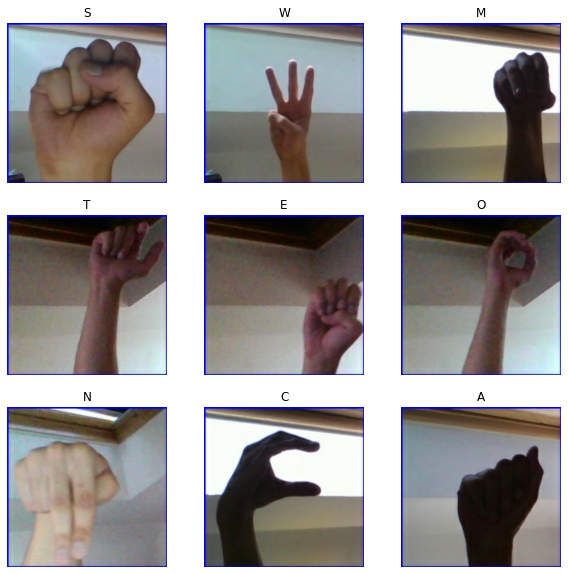

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, groundlabels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    classid=groundlabels[i].numpy()
    print(classid)
    plt.title(class_names[classid])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [17]:
image_batch

<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 2.46000000e+02],
         [0.00000000e+00, 6.71875000e-01, 2.46671875e+02],
         [0.00000000e+00, 5.46875000e-01, 2.43828125e+02],
         ...,
         [9.06250000e-01, 0.00000000e+00, 2.38000000e+02],
         [0.00000000e+00, 0.00000000e+00, 2.38000000e+02],
         [0.00000000e+00, 0.00000000e+00, 2.38000000e+02]],

        [[0.00000000e+00, 2.01562500e+00, 2.48015625e+02],
         [0.00000000e+00, 8.81835938e-01, 2.36950684e+02],
         [2.43554688e+00, 1.70166016e+00, 2.25026123e+02],
         ...,
         [3.70922852e+00, 1.34375000e+00, 2.09676270e+02],
         [6.71875000e-01, 2.44604492e+00, 2.18022217e+02],
         [6.71875000e-01, 4.70312500e+00, 2.23890625e+02]],

        [[0.00000000e+00, 1.64062500e+00, 2.42656250e+02],
         [2.73999023e+00, 2.06054688e+00, 2.24032715e+02],
         [2.37182617e+01, 2.13676758e+01, 2.11093018e+02],
         ...,
         [

In [18]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#There are two ways to use this layer. You can apply it to the dataset by calling map:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

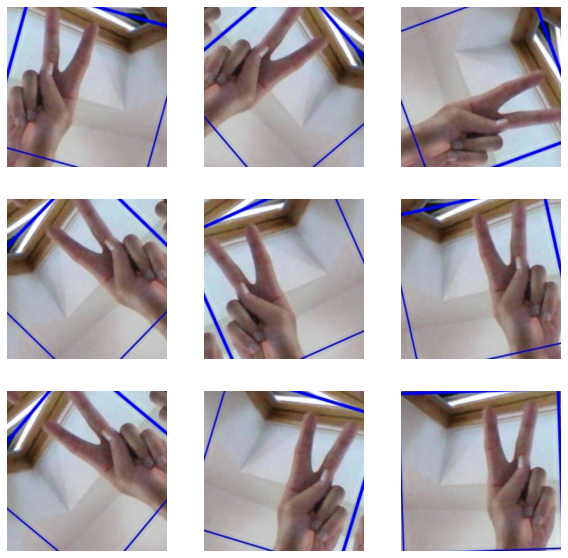

In [20]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [21]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [22]:
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
IMG_SHAPE

(256, 256, 3)

In [24]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [25]:
base_model.trainable = False

In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [27]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [28]:
prediction_layer = tf.keras.layers.Dense(29)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 29)


In [29]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 29) dtype=float32, numpy=
 array([[-0.00197544,  0.03874125,  0.06667695, ..., -0.00452364,
         -0.06204797, -0.0140719 ],
        [ 0.03109895, -0.0383979 ,  0.00111805, ..., -0.05057507,
          0.02100457,  0.02238677],
        [-0.01734741, -0.00682965, -0.04361144, ...,  0.06021213,
          0.04715858, -0.01166928],
        ...,
        [-0.06769317,  0.03438327,  0.03448591, ..., -0.05575655,
          0.05830651,  0.03600205],
        [-0.03526476,  0.03717496, -0.05177265, ..., -0.00435112,
          0.04094054, -0.06135853],
        [-0.02897629, -0.02281975, -0.01976964, ..., -0.04518435,
         -0.03215526,  0.0276485 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(29,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [33]:
loss0, accuracy0 = model.evaluate(val_ds)

544/544 [==============================] - 35s 60ms/step - loss: 3.7097 - accuracy: 0.0389


In [34]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.71
initial accuracy: 0.04


In [35]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds)

Epoch 1/30
2175/2175 [==============================] - 202s 92ms/step - loss: 2.3095 - accuracy: 0.3785 - val_loss: 1.3048 - val_accuracy: 0.7211
Epoch 2/30
2175/2175 [==============================] - 198s 91ms/step - loss: 1.3600 - accuracy: 0.6533 - val_loss: 0.8600 - val_accuracy: 0.8115
Epoch 3/30
2175/2175 [==============================] - 200s 92ms/step - loss: 1.0417 - accuracy: 0.7339 - val_loss: 0.6670 - val_accuracy: 0.8508
Epoch 4/30
2175/2175 [==============================] - 200s 92ms/step - loss: 0.8712 - accuracy: 0.7731 - val_loss: 0.5648 - val_accuracy: 0.8709
Epoch 5/30
2175/2175 [==============================] - 200s 92ms/step - loss: 0.7674 - accuracy: 0.7983 - val_loss: 0.4958 - val_accuracy: 0.8825
Epoch 6/30
2175/2175 [==============================] - 199s 92ms/step - loss: 0.6958 - accuracy: 0.8157 - val_loss: 0.4502 - val_accuracy: 0.8924
Epoch 7/30
2175/2175 [==============================] - 200s 92ms/step - loss: 0.6433 - accuracy: 0.8275 - val_loss: 0

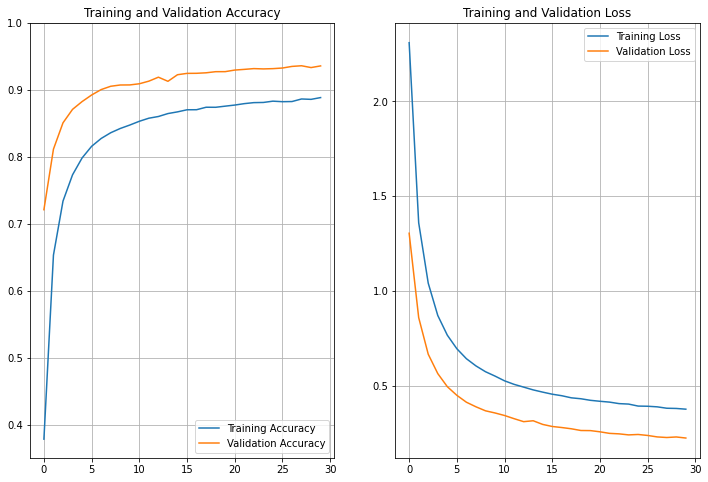

In [36]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()
  fig.savefig('traininghistory.pdf')

plot_history(history, 'accuracy', 'val_accuracy')

## old

In [ ]:
import os

num_skipped=0
for folder_name in ("A","B","C","D","E","F","G","H","I","J","K"):
    folder_path = os.path.join("/content/asl_alphabet_train/asl_alphabet_train",folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)



Deleted 0 images


Dataset Generation

In [ ]:
import cv2
import numpy as np

In [ ]:
img = cv2.imread("/content/asl_alphabet_train/asl_alphabet_train/A/A1.jpg")

In [ ]:
img.shape

(200, 200, 3)

In [ ]:
image_size = (200, 200)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 87029 files belonging to 29 classes.
Using 69624 files for training.
Found 87029 files belonging to 29 classes.
Using 17405 files for validation.


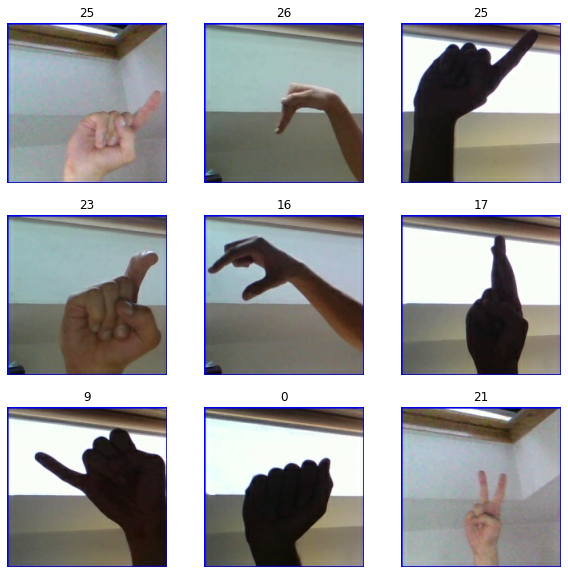

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


Apply Adjustment to image such as flip, rotate and shrink

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
    ]
)


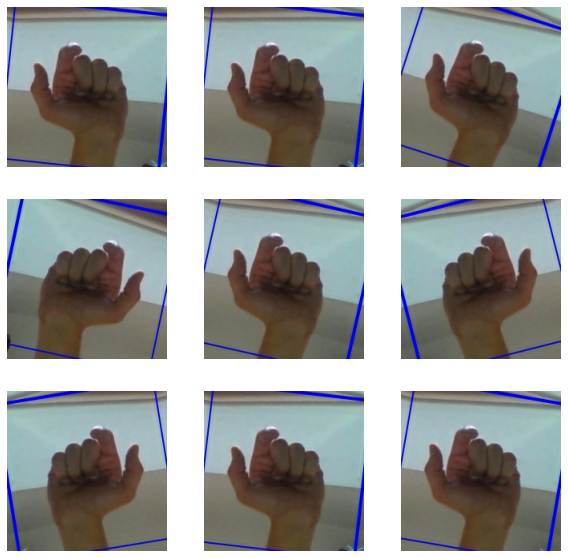

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [ ]:
tf.data.Dataset.save(train_ds,'/content/drive/MyDrive/CMPE255_ASL_PROJECT/preprocess_ds/val_ds_asl')